In [16]:
import pandas as pd
import psycopg2

# Use existing connection
# Load NBA master games into dataframe
nba_games_df = pd.read_sql_query("SELECT * FROM wnba_games ORDER BY gameid", conn)


C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\3005639909.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  nba_games_df = pd.read_sql_query("SELECT * FROM wnba_games ORDER BY gameid", conn)


<Axes: title={'center': 'NBA Games by Year'}, xlabel='year'>

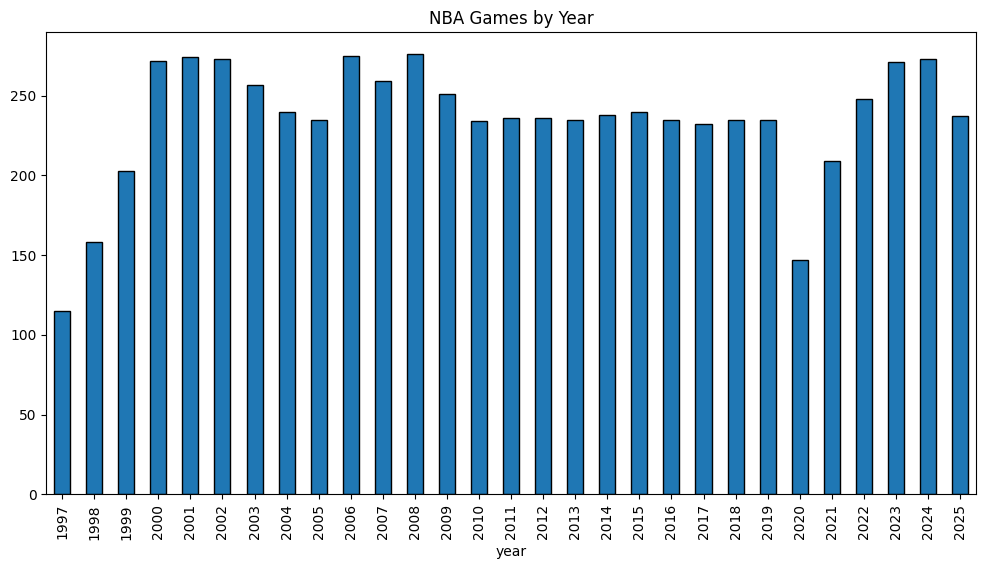

In [17]:
nba_games_df['year'] = pd.to_datetime(nba_games_df['gamedate']).dt.year
nba_games_df['year'].value_counts().sort_index().plot.bar(
    figsize=(12,6), 
    edgecolor='black', 
    title='NBA Games by Year'
)

In [15]:
nba_games_df

,gameid,seasonid,gamedate,hometeamid,hometeamabbreviation,hometeamname,awayteamid,awayteamabbreviation,awayteamname,matchup,homewl,awaywl,seasontype,leaguename,createdat,updatedat,year
0,0010300001,002003-04,2003-10-05,1610612742,DAL,Dallas Mavericks,1610612762,UTA,Utah Jazz,UTA vs. DAL,L,W,Pre Season,NBA,2025-08-11 18:58:39.015456,2025-08-11 18:58:39.015456,2003
1,0010300002,002003-04,2003-10-06,1610612763,MEM,Memphis Grizzlies,1610612749,MIL,Milwaukee Bucks,MIL @ MEM,W,L,Pre Season,NBA,2025-08-11 18:58:39.015456,2025-08-11 18:58:39.015456,2003
2,0010300003,002003-04,2003-10-07,1610612765,DET,Detroit Pistons,1610612739,CLE,Cleveland Cavaliers,CLE @ DET,L,W,Pre Season,NBA,2025-08-11 18:58:39.015456,2025-08-11 18:58:39.015456,2003
3,0010300004,002003-04,2003-10-07,1610612753,ORL,Orlando Magic,1610612742,DAL,Dallas Mavericks,DAL vs. ORL,L,W,Pre Season,NBA,2025-08-11 18:58:39.015456,2025-08-11 18:58:39.015456,2003
4,0010300005,002003-04,2003-10-07,1610612745,HOU,Houston Rockets,1610612757,POR,Portland Trail Blazers,POR vs. HOU,L,W,Pre Season,NBA,2025-08-11 18:58:39.015456,2025-08-11 18:58:39.015456,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52777,0049900084,001999-00,2000-06-09,1610612747,LAL,Los Angeles Lakers,1610612754,IND,Indiana Pacers,IND @ LAL,W,L,Playoffs,NBA,2025-08-11 18:57:25.239257,2025-08-11 18:57:25.239257,2000
52778,0049900085,001999-00,2000-06-11,1610612754,IND,Indiana Pacers,1610612747,LAL,Los Angeles Lakers,LAL @ IND,W,L,Playoffs,NBA,2025-08-11 18:57:25.239257,2025-08-11 18:57:25.239257,2000
52779,0049900086,001999-00,2000-06-14,1610612754,IND,Indiana Pacers,1610612747,LAL,Los Angeles Lakers,LAL @ IND,L,W,Playoffs,NBA,2025-08-11 18:57:25.239257,2025-08-11 18:57:25.239257,2000
52780,0049900087,001999-00,2000-06-16,1610612747,LAL,Los Angeles Lakers,1610612754,IND,Indiana Pacers,IND vs. LAL,L,W,Playoffs,NBA,2025-08-11 18:57:25.239257,2025-08-11 18:57:25.239257,2000


In [20]:
# Compare Master Games vs Endpoint Data vs Failed API Calls
print("🔍 GAMES COLLECTION ANALYSIS")
print("="*50)

# Get all master games (all leagues)
master_games_query = """
SELECT DISTINCT gameid FROM (
    SELECT gameid FROM nba_games
) AS all_games
ORDER BY gameid
"""
master_games_df = pd.read_sql_query(master_games_query, conn)
master_gameids = set(master_games_df['gameid'])

print(f"📊 Master Games (all leagues): {len(master_gameids):,}")

# Get games from boxscoretraditionalv3 endpoint tables (with league prefix and _n suffix)
endpoint_gameids = set()
boxscore_tables = []

# Check for NBA boxscoretraditionalv3 tables with nba_ prefix and _n suffix
for i in range(10):  # Check _0 through _9
    table_name = f"nba_boxscoretraditionalv3_{i}"
    try:
        test_query = f"SELECT COUNT(*) FROM {table_name}"
        pd.read_sql_query(test_query, conn)
        boxscore_tables.append(table_name)
        
        # Get gameids from this table
        games_df = pd.read_sql_query(f"SELECT DISTINCT gameid FROM {table_name}", conn)
        table_gameids = set(games_df['gameid'])
        endpoint_gameids.update(table_gameids)
        print(f"✅ {table_name}: {len(table_gameids):,} games")
        
    except Exception:
        # Table doesn't exist, skip
        continue

if endpoint_gameids:
    print(f"📊 Total BoxScore Traditional V3 Games: {len(endpoint_gameids):,}")
else:
    print(f"❌ BoxScore Traditional V3: No tables found")
    
print(f"📋 Found tables: {boxscore_tables}")

# Get failed API calls
try:
    failed_games_df = pd.read_sql_query(
        "SELECT DISTINCT id_value as gameid FROM failed_api_calls WHERE id_column = 'gameid'", 
        conn
    )
    failed_gameids = set(failed_games_df['gameid'])
    print(f"🚫 Failed API Calls: {len(failed_gameids):,}")
except Exception as e:
    print(f"❌ Failed API Calls: Table not found or empty")
    failed_gameids = set()

# Calculate what's missing
successfully_collected = endpoint_gameids
attempted_but_failed = failed_gameids
never_attempted = master_gameids - successfully_collected - attempted_but_failed

print(f"\n📈 BREAKDOWN:")
print(f"   ✅ Successfully Collected: {len(successfully_collected):,}")
print(f"   🚫 Attempted but Failed: {len(attempted_but_failed):,}")
print(f"   ❓ Never Attempted: {len(never_attempted):,}")
print(f"   🎯 TOTAL MISSING: {len(attempted_but_failed) + len(never_attempted):,}")

# Calculate percentages
if len(master_gameids) > 0:
    success_pct = (len(successfully_collected) / len(master_gameids)) * 100
    failed_pct = (len(attempted_but_failed) / len(master_gameids)) * 100
    never_pct = (len(never_attempted) / len(master_gameids)) * 100
    
    print(f"\n📊 PERCENTAGES:")
    print(f"   ✅ Success Rate: {success_pct:.1f}%")
    print(f"   🚫 Failed Rate: {failed_pct:.1f}%") 
    print(f"   ❓ Never Attempted: {never_pct:.1f}%")

print(f"\n🎯 GAMES LEFT TO PULL: {len(master_gameids) - len(successfully_collected):,}")
print("="*50)

🔍 GAMES COLLECTION ANALYSIS


C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\1461087976.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  master_games_df = pd.read_sql_query(master_games_query, conn)


📊 Master Games (all leagues): 52,782


C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\1461087976.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql_query(test_query, conn)
C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\1461087976.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games_df = pd.read_sql_query(f"SELECT DISTINCT gameid FROM {table_name}", conn)
C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\1461087976.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games_df = pd.read_sql_query(f"SELECT DISTINCT gameid FROM {table_name}", 

✅ nba_boxscoretraditionalv3_0: 25,813 games
✅ nba_boxscoretraditionalv3_1: 25,812 games
✅ nba_boxscoretraditionalv3_1: 25,812 games
✅ nba_boxscoretraditionalv3_2: 25,812 games
✅ nba_boxscoretraditionalv3_2: 25,812 games
📊 Total BoxScore Traditional V3 Games: 25,813
📋 Found tables: ['nba_boxscoretraditionalv3_0', 'nba_boxscoretraditionalv3_1', 'nba_boxscoretraditionalv3_2']
🚫 Failed API Calls: 1,061

📈 BREAKDOWN:
   ✅ Successfully Collected: 25,813
   🚫 Attempted but Failed: 1,061
   ❓ Never Attempted: 26,819
   🎯 TOTAL MISSING: 27,880

📊 PERCENTAGES:
   ✅ Success Rate: 48.9%
   🚫 Failed Rate: 2.0%
   ❓ Never Attempted: 50.8%

🎯 GAMES LEFT TO PULL: 26,969
📊 Total BoxScore Traditional V3 Games: 25,813
📋 Found tables: ['nba_boxscoretraditionalv3_0', 'nba_boxscoretraditionalv3_1', 'nba_boxscoretraditionalv3_2']
🚫 Failed API Calls: 1,061

📈 BREAKDOWN:
   ✅ Successfully Collected: 25,813
   🚫 Attempted but Failed: 1,061
   ❓ Never Attempted: 26,819
   🎯 TOTAL MISSING: 27,880

📊 PERCENTAGES:


C:\Users\ajwin\AppData\Local\Temp\ipykernel_5940\1461087976.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  failed_games_df = pd.read_sql_query(


In [ ]:
# Show sample games from each category
print("\n📋 SAMPLE GAMES BY CATEGORY")
print("="*40)

if successfully_collected:
    print(f"\n✅ SUCCESSFULLY COLLECTED (showing first 5):")
    sample_success = sorted(list(successfully_collected))[:5]
    for game in sample_success:
        print(f"   {game}")
else:
    print(f"\n✅ SUCCESSFULLY COLLECTED: None")

if attempted_but_failed:
    print(f"\n🚫 ATTEMPTED BUT FAILED (showing first 5):")
    sample_failed = sorted(list(attempted_but_failed))[:5]
    for game in sample_failed:
        print(f"   {game}")
else:
    print(f"\n🚫 ATTEMPTED BUT FAILED: None")

if never_attempted:
    print(f"\n❓ NEVER ATTEMPTED (showing first 10):")
    sample_never = sorted(list(never_attempted))[:10]
    for game in sample_never:
        print(f"   {game}")
        
    print(f"\n🎯 PRIORITY FOR NEXT COLLECTION:")
    print(f"   Focus on the {len(never_attempted):,} games that were never attempted")
    print(f"   Consider retrying the {len(attempted_but_failed):,} games that failed")
else:
    print(f"\n❓ NEVER ATTEMPTED: None")

print("="*40)